# Basic mitigated VQE

This test is described in [8]. It takes the sample Hamiltonian H= 0.3979YZ -0.3979ZI -0.01128ZZ + 0.1809XX and calculates the expected energy value.

[8] https://qiskit.org/ecosystem/mthree/tutorials/10_basic_vqe.html

In [1]:
import numpy as np
import scipy.optimize as opt
from qiskit import *
from qiskit.circuit.library import TwoLocal
from qiskit.providers.fake_provider import FakeAthens
import mthree
from time import time

In [2]:
# Problem
# hamiltonian
H_op = [(0.39793742484318045, 'YZ'), (-0.39793742484318045, 'ZI'),
       (-0.01128010425623538, 'ZZ'), (0.18093119978423156, 'XX')]
ansatz = TwoLocal(2, rotation_blocks='ry', entanglement_blocks='cx')

# extract needed data
coeffs = np.array([item[0] for item in H_op], dtype=float)
op_strings = [item[1] for item in H_op]

def opstr_to_meas_circ(op_str):
    """Takes a list of operator strings and makes circuit with the correct post-rotations for measurements.

    Parameters:
        op_str (list): List of strings representing the operators needed for measurements.

    Returns:
        list: List of circuits for measurement post-rotations
    """
    num_qubits = len(op_str[0])
    circs = []
    for op in op_str:
        qc = QuantumCircuit(num_qubits)
        for idx, item in enumerate(op):
            if item == 'X':
                qc.h(num_qubits-idx-1)
            elif item == 'Y':
                qc.sdg(num_qubits-idx-1)
                qc.h(num_qubits-idx-1)
        circs.append(qc)
    return circs

[(0.39793742484318045, 'YZ'), (-0.39793742484318045, 'ZI'), (-0.01128010425623538, 'ZZ'), (0.18093119978423156, 'XX')]
['ZZ', 'ZI', 'ZZ', 'ZZ']


None

None

None

None

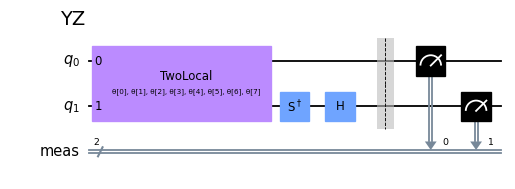

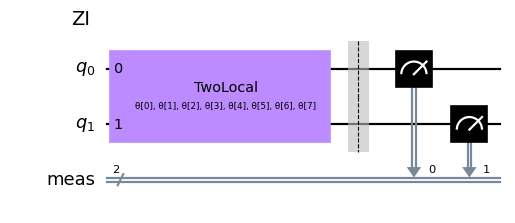

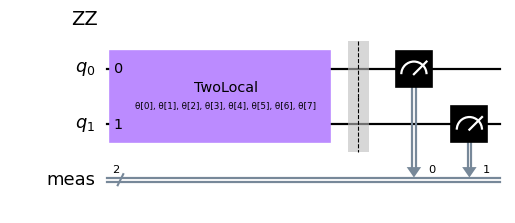

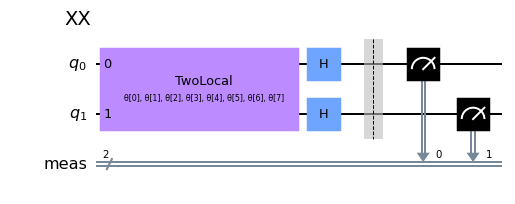

In [3]:
# circuits
meas_circs = opstr_to_meas_circ(op_strings)
full_circs = [ansatz.compose(meas_circs[kk]).measure_all(inplace=False) for kk in range(len(meas_circs))]
meas_strings = [string.replace('X', 'Z').replace('Y', 'Z') for string in op_strings]

print (H_op)
print (meas_strings)

# transpile
backend = FakeAthens()
trans_circs = transpile(full_circs, backend)
#trans_circs[0].draw('mpl')

from matplotlib.pyplot import figure

i = 0
for qc in full_circs:
    fig = figure()
    ax = fig.add_subplot()
    height = 0.8
    ax.text(-0.9, height, op_strings[i], size=14)
    display(qc.draw('mpl', ax=ax))
    i += 1

In [4]:
# Set initial params
num_params = ansatz.num_parameters
params = np.array([1.22253725, 0.39053752, 0.21462153, 5.48308027,
                   2.06984514, 3.65227416, 4.01911194, 0.35749589])
params += 0.05*(np.random.random(params.shape[0])-0.5)

In [7]:
# m3 mitigation setup
mit = mthree.M3Mitigation(backend)

start       = time()
mit.cals_from_system([0,1])
end        = time()
print(f'M3 calibration time (ms): {(end - start)*1000:.2f}')

def vqe_m3_func(params, *args):
    # Attach parameters to the transpiled circuit variables
    bound_circs = [circ.bind_parameters(params) for circ in trans_circs]
    # Submit the job and get the resultant counts back
    counts = backend.run(bound_circs, shots=4096).result().get_counts()
    
    # Apply mitigation to get quasi-probabilities
    quasis = mit.apply_correction(counts, [0,1])
    vals = quasis.expval(meas_strings)
    
    #print (quasis)
    #print (vals)
    
    # Evaluate the coefficients times each expectation value obtained from quasi-probabilities and sum.
    energy = np.sum(coeffs * vals)
    return energy

M3 calibration time (ms): 190.00


In [6]:
# image filter mitogation setup
import mitigation as mitigation

def vqe_image_func(params, *args):
    # Attach parameters to the transpiled circuit variables
    bound_circs = [circ.bind_parameters(params) for circ in trans_circs]
    shots=4096
    
    # Submit the job and get the resultant counts back
    counts = backend.run(bound_circs, shots=shots).result().get_counts()

    # Apply mitigation to get quasi-probabilities
    in_range =  (0.01, 0.99) # 'image'
    quasis = mitigation.get_probabilities(counts, shots, in_range = in_range)
    vals   = mitigation.expval(quasis, meas_strings)
    #print (vals)
    #print (quasis)
    
    # Evaluate the coefficients times each expectation value obtained from quasi-probabilities and sum.
    energy = np.sum(coeffs * vals)
    return energy


The image intensity filter method performs better than M3, yielding a more accurate estimate of the final energy of the Hamiltonian

In [10]:
# results M3
start       = time()
res = opt.minimize(vqe_m3_func, params, method = 'COBYLA')
end        = time()
print(f'VQE with M3 optimization time (ms): {(end - start)*1000:.2f}')

print(res.fun)
print(np.mod(res.x, 2*np.pi))

VQE with M3 optimization time (ms): 12572.20
-0.41739931839700883
[1.12809113 0.14388503 0.45592121 5.6373008  1.85307064 3.32095606
 3.98170512 6.27290015]


In [11]:
# image filter results
start       = time()
res1 = opt.minimize(vqe_image_func, params, method = 'COBYLA')
end        = time()
print(f'VQE with filter at 1% optimization time (ms): {(end - start)*1000:.2f}')

print(res1.fun)
print(np.mod(res1.x, 2*np.pi))

VQE with filter at 1% optimization time (ms): 12177.21
-0.43768645693091013
[1.18962316 0.34093708 0.22369138 5.61001833 2.02460079 3.67174907
 4.02032405 0.34809543]


The optimal solution is around: -0.44841884382998787
See https://qiskit.org/ecosystem/mthree/tutorials/10_basic_vqe.html